# Flower Identifier
This notebook demonstrates how to train a deep learning model to classify flowers from the Oxford Flowers 102 dataset using TensorFlow and Keras. The model uses transfer learning with MobileNetV2 as the base model.

In [121]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

## Loading and Exploring the Dataset

We will be using the Oxford Flowers 102 dataset, which contains 102 flower classes. We will load the dataset, check the number of images in each split, and explore the class distribution.

In [122]:
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['validation']

In [123]:
# Dataset size and class information
num_training = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples

print(f'Training set size: {num_training}')
print(f'Validation set size: {num_validation}')
print(f'Test set size: {num_test}')

num_classes = info.features['label'].num_classes
print(f'Number of Classes: {num_classes}')

Training set size: 1020
Validation set size: 1020
Test set size: 6149
Number of Classes: 102


## Visualizing the Dataset

Let's explore the class distribution and visualize some sample images from the training set.

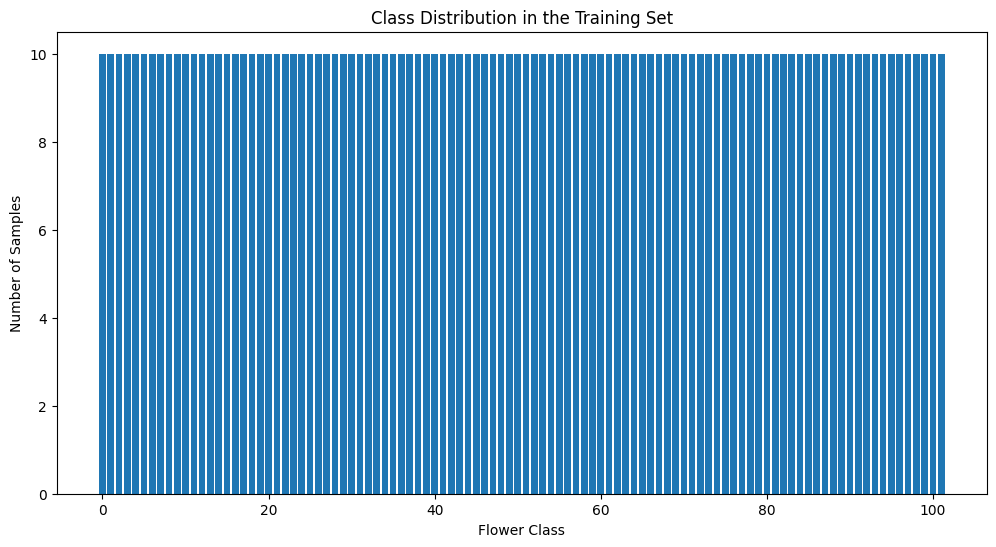

In [124]:
labels = []
for _, label in train_dataset:
    labels.append(label.numpy())

unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts)
plt.xlabel('Flower Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Training Set')
plt.show()

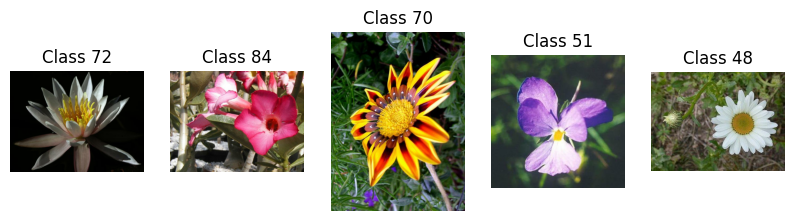

In [125]:
# Function to display random images
def plot_random_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(f'Class {label.numpy()}')
    plt.show()

# Display random images from the training set
plot_random_images(train_dataset)

## Preprocessing

We will resize the images to 224x224 and normalize pixel values to be between 0 and 1.

In [126]:
IMG_SIZE = 224

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the pixel values to [0, 1]
    return image, label

In [128]:
train_dataset = train_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)

## Building the Model

We will use MobileNetV2 as the base model, with weights pre-trained on ImageNet. The base model will be frozen, and we will add a Global Average Pooling layer followed by a dense output layer with 102 units, corresponding to the 102 flower classes.

In [129]:
# Load model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [130]:
# Freeze the base model
base_model.trainable = False

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(102, activation='softmax')
])

In [131]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training the Model

Now, we will train the model for 11 epochs and monitor its performance on the validation dataset.

In [132]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=val_dataset
)

Epoch 1/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.0946 - loss: 4.7067 - val_accuracy: 0.4814 - val_loss: 2.4780
Epoch 2/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step - accuracy: 0.7897 - loss: 1.5515 - val_accuracy: 0.6755 - val_loss: 1.6187
Epoch 3/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.9279 - loss: 0.7530 - val_accuracy: 0.7373 - val_loss: 1.2861
Epoch 4/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.9794 - loss: 0.4393 - val_accuracy: 0.7529 - val_loss: 1.1165
Epoch 5/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.9932 - loss: 0.2810 - val_accuracy: 0.7706 - val_loss: 1.0164
Epoch 6/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - accuracy: 0.9970 - loss: 0.1916 - val_accuracy: 0.7814 - val_loss: 0.9526
Epoch 7/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 1.0000 - loss: 0.1385 - val_accuracy: 0.7863 - val_loss: 0.9087
Epoch 8/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 1.0000 - loss: 0.1050 - val_accu

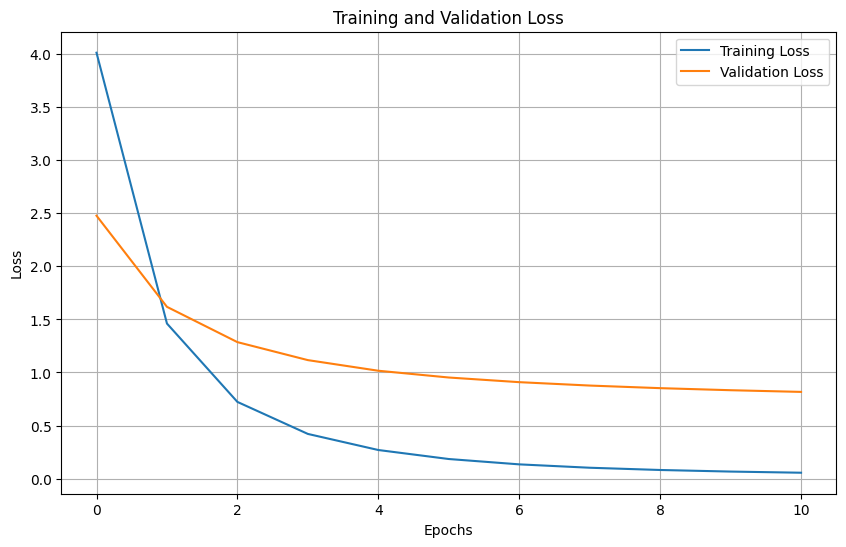

In [134]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

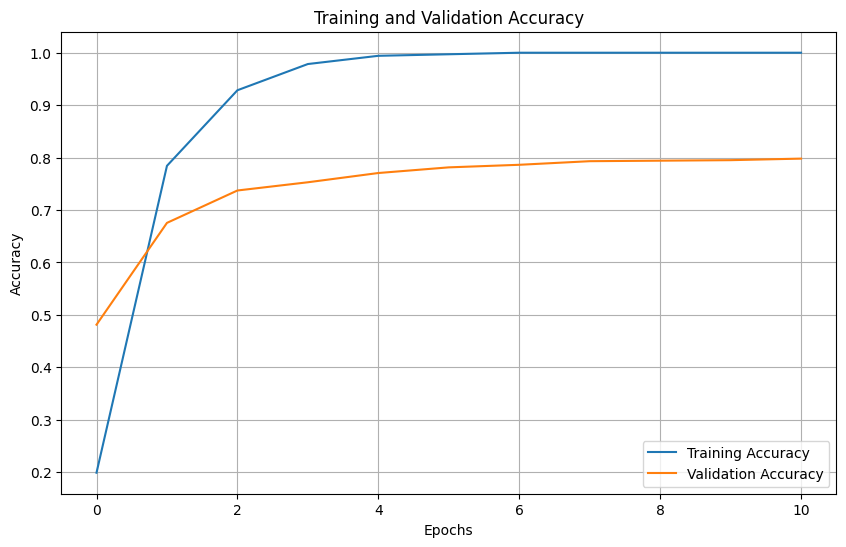

In [135]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating the Model

Finally, we will evaluate the model on the test dataset and display the accuracy.

In [133]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

385/385 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.7756 - loss: 0.9542
Test accuracy : 0.7702065110206604


In this section, we will generate and visualize a confusion matrix for the flower classification model to evaluate its performance. The confusion matrix will help us understand how well the model predicts each class (flower type) and where it tends to make mistakes. We will also visualize a zoomed-in version showing only the most misclassified labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

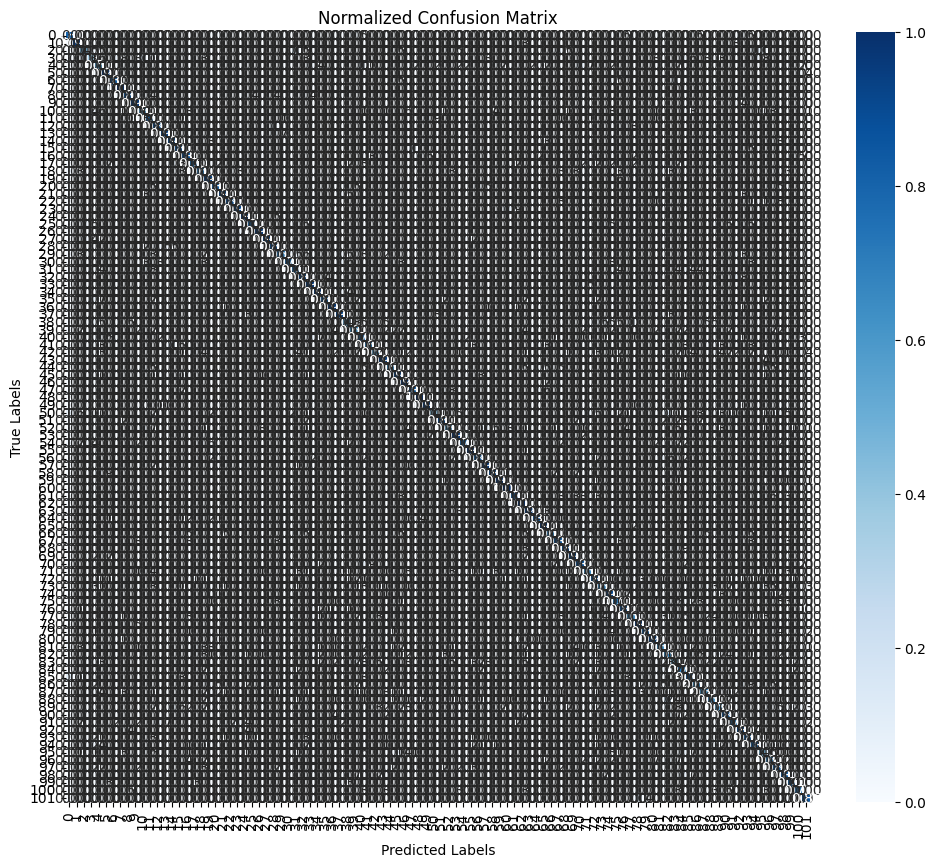

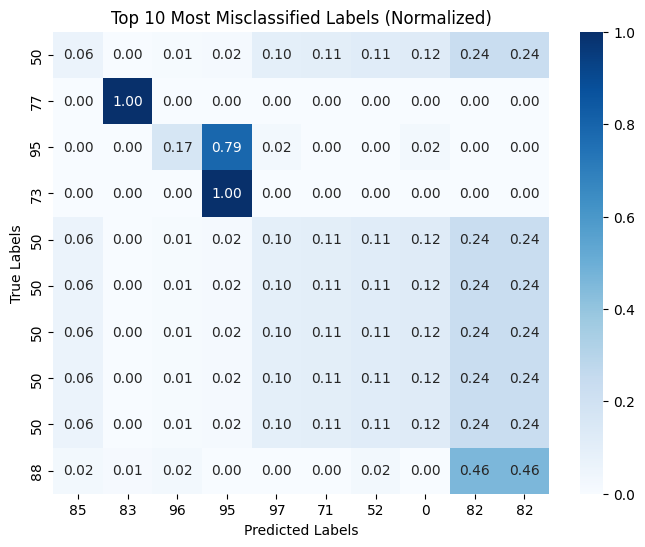

In [137]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Get true labels and predictions
true_labels = []
pred_labels = []

# Iterate through the test dataset and gather true and predicted labels
for images, labels in test_dataset:
    # Get model predictions (probabilities)
    predictions = model.predict(images)
    
    # Convert probabilities to class labels (by picking the class with the highest probability)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    # Extend true and predicted labels lists
    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Convert true_labels to a numpy array for compatibility
true_labels = np.array(true_labels)

# Compute the confusion matrix using scikit-learn
cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))

# Normalize the confusion matrix (by rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the full normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Get the indices of the top 10 most misclassified classes (off-diagonal values)
misclassifications = np.abs(cm - np.diag(np.diagonal(cm)))  # Absolute values of off-diagonal elements
top_misclassified_indices = np.unravel_index(np.argsort(misclassifications.ravel())[-10:], misclassifications.shape)

# Plot confusion matrix for only the top 10 misclassified classes
cm_top10 = cm[np.ix_(top_misclassified_indices[0], top_misclassified_indices[1])]

# Normalize the confusion matrix for these top 10 classes
cm_top10_normalized = cm_top10.astype('float') / cm_top10.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_top10_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=top_misclassified_indices[1], yticklabels=top_misclassified_indices[0])
plt.title('Top 10 Most Misclassified Labels (Normalized)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Saving the Model

In [140]:
model.save('flower_identifier_model.keras')